# Tarea 3. Concurso CartoonImageNet
## Arnoldo Fernando Chue Sánchez

En este notebook únicamente presentamos el modelo que mejor desempeño tuvo. Para ver los experimentos es en el otro archivo.

Simplemente es de correr toda la libreta. 

Se tomaron en cuenta todas las restricciones de la tarea. Únicamente hay que cuidar el tiempo, ya que la tarea se hizo con una tarjeta de video con 16GB de memoria dedicada. Ahí cada época duraba menos de los 2 minutos permitidos

In [1]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import prod, sqrt, log, exp
from pathlib import Path

In [2]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(max_rotate=30, # vamos a rotar ligeramente las imagenes (si tenemos bajo ajuste igual le bajamos si se nos pasó la mano)
                             max_lighting=0.25,
                             max_zoom=1.2,
                             max_warp=0.2
                             )
    
    data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                        get_items = fv.get_image_files,
                        get_y = fv.parent_label,
                        splitter = fv.GrandparentSplitter(),
                        item_tfms = fv.Resize(img_size),
                        batch_tfms = tfms,
                        )
    
    return data.dataloaders(folder, batch_size=batch_size)

In [3]:
def num_params(model):
    return sum([prod(p.shape) for p in model.parameters()])

In [4]:
def create_identity_conv_weight(ni, no=None, k=3, s=1, device='cpu'):
    if no is None: no = ni
    noo = no if no >= ni else ni
    T = torch.zeros(noo, ni, k, k, device=device)
    I = torch.arange(ni, device=device)
    a = (k - s)//2
    b = a + s
    T[I, I, a:b, a:b] = 1/s**2
    return T[:no]

def init_conv_weight(w, nc, g, s):
    no, ni, k, k, = w.shape
    no //= g
    with torch.no_grad():
        for i in range(g):
            c = min(ni, nc, no)
            start = i*no
            end = start + c
            w[start:end] = create_identity_conv_weight(ni, c, k, s, w.device)
            nc -= c
            if nc <= 0: break

def init_id_conv(conv, wd=1., nc=None):
    conv.init_id = True
    conv.wd = wd

    no, ni, k, k = conv.weight.shape
    g = conv.groups
    s = conv.stride[0]

    if nc is None: nc = min(no, ni*g)
    assert(0 < nc <= min(no, ni*g))
    conv.nc = nc

    if conv.bias is not None: nn.init.constant_(conv.bias, 0.)

    init_conv_weight(conv.weight, nc, g, s)


def identity(x): return x

def conv2d(ni, no, k=3, s=1, pad="same", g=1, init='none', bias=True, nc=None):
    if pad == "same": pad = (k-1)//2

    conv = nn.Conv2d(ni, no, kernel_size=k, stride=s, padding=pad, groups=g, bias=bias)

    if bias: nn.init.constant_(conv.bias, 0.)

    if not fv.is_listy(init): init = [init]

    if 'linear' in init: nn.init.kaiming_normal_(conv.weight, nonlinearity=init)
    else: nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

    if 'id' in init or 'avg' in init: init_id_conv(conv, nc=nc)
    
    return conv

In [5]:
import inspect

def delegates(to=None, keep=False):
    def _f(f):
        if to is None: to_f, from_f = f.__base__.__init__, f.__init__
        else: to_f, from_f = to, f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k, v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

relu = nn.ReLU(inplace=False)
default_act = relu

def init_bn_to_0(bn, wd=1.):
    nn.init.constant_(bn.weight, 0.)
    bn.init_zero = True
    bn.wd = wd

@delegates(conv2d)
def bca(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p=0., init='relu', **kwargs):
    layers = []

    if bn:
        layers += [nn.BatchNorm2d(ni)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    layers += [conv2d(ni, no, bias=(not bn), **kwargs)]

    if activation: layers += [act_fn]

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

In [6]:
leaky_i = nn.LeakyReLU(1/16, inplace=True)

def lab(ni, no, bn=True, activation=True, act_fn=leaky_i, bn_init_zero=False, p=0.):
    layers = []

    layers += [nn.Linear(ni, no)]

    if activation: layers += [act_fn]

    if p > 0: layers += [nn.Dropout(p)]

    if bn:
        layers += [nn.BatchNorm1d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    return layers

In [7]:
celu = nn.CELU(inplace=False)

def _get_bn_weight(A):
    if not isinstance(A, nn.Sequential): return 1
    if isinstance(A[-1], nn.BatchNorm2d): return A[-1].weight[None, :, None, None]
    return 1

class SmartAdd(nn.Module):
    def __init__(self, A, B):
        super().__init__()
        self.pathA = A
        self.pathB = B

    def forward(self, x):
        A, B = self.pathA, self.pathB

        a = _get_bn_weight(A)
        b = _get_bn_weight(B)

        divider = torch.sqrt(a*a + b*b) + 1e-6
        divider = divider.to(x)

        return (A(x) + B(x))/divider

@delegates(conv2d)
def cba(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., init='relu', **kwargs):
    layers = []
    
    layers += [conv2d(ni, no, init=init, bias=(not bn), **kwargs)]
    
    if bn:
        layers += [nn.BatchNorm2d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    if activation: layers += [act_fn]

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

@delegates(conv2d)
def acb(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., init='relu', **kwargs):
    layers = []
    
    if activation: layers += [act_fn]
    
    layers += [conv2d(ni, no, init=init, bias=(not bn), **kwargs)]
    
    if bn:
        layers += [nn.BatchNorm2d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

def residual_builder(res_func, ni, no=None, s=1, use_pool=False, pre_activate=True, pre_act=celu, post_bn=True, **kwargs):
    if no is None: no = ni

    k = 3 if s == 1 else 4

    pool = identity
    if use_pool or s == 2 or no != ni:
        pool = conv2d(ni, no, k=k, s=s, init='avg')
        pre_activate = True
        post_bn = True

    layers = []

    if pre_activate: layers += [pre_act]
    if post_bn: layers += [nn.BatchNorm2d(ni)]

    residual = res_func(ni=ni, no=no, k=k, s=s, **kwargs)

    if not pre_activate: residual = [pre_act, *residual]    

    residual = nn.Sequential(*residual)
    rblock = SmartAdd(pool, residual)
    layers += [rblock]

    return nn.Sequential(*layers)

@delegates(residual_builder)
def ResBlock(ni, no=None, bottle=None, g=1, **kwargs):
    def _normal_residual(ni, no, bottle, k, s, g):
        if bottle is None: bottle = ni // 2
        return nn.Sequential(*cba(ni, bottle, g=g, activation=False),
                             *acb(bottle, no, k=k, s=s, g=g, bn_init_zero=True))
    
    return residual_builder(_normal_residual, ni, no, bottle=bottle, g=g, **kwargs)

In [8]:
@delegates(conv2d)
def abc(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., **kwargs):
    layers = []
    
    if activation: layers += [act_fn]
    if p > 0: layers += [nn.Dropout2d(p)]

    if bn:
        layers += [nn.BatchNorm2d(ni)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    layers += [conv2d(ni, no, bias=(not bn), **kwargs)]

    return layers

@delegates(abc)
def abc_block(ni,no,**kwargs):
    return nn.Sequential(*abc(ni,no,**kwargs))

class Stair(nn.Module):
    """groups should be an integer, or 'full' or 'mid' or a list of no//steps - 1 integers"""
    def __init__(self, ni, no=None, steps=4, k=3, s=1, groups = 1, act_fn=default_act):
        super().__init__()
        if no is None: no = ni
        
        if fv.is_listy(groups): steps = len(groups)+1
        p = steps
        
        assert(ni%p == 0 and no%p==0)
        t = no//p
        
        if type(groups) == int: groups = [groups]*(p-1)
        
        gg = groups
        if gg in ['full', 'mid']: groups = [p-i for i in range(1,p)]
        if gg == 'mid':
            groups = [(g if g%2==1 else g//2) for g in groups]
                
        assert(len(groups) == p-1)
        #print("groups = ", groups)
        self.t = t
        
        modules = [conv2d(ni,no,k=k,s=s)]
        modules += [abc_block((p-i)*t,(p-i)*t,act_fn=act_fn,g=g,init='avg') for i,g in zip(range(1,p),groups)]
        self.convs = nn.ModuleList(modules)
    
    def forward(self, x):
        t, convs = self.t, self.convs
        
        out = []
        
        for c in convs:
            #print(f"{i}: {c[1].in_channels}->{c[1].out_channels}, and x.shape={x.shape}")
            x = c(x)
            out.append(x[:,:t])
            x = x[:,t:]
            
        return torch.cat(out,dim=1)
    
@delegates(residual_builder)
def ResStairBlock(ni, no=None, bottle=None, steps=4, groups = 1, **kwargs):
    def _stair_residual(ni,no,bottle,k,s,steps,groups):
        if bottle is None: bottle = ni//2
        return nn.Sequential(Stair(ni, bottle, k=k, s=s, steps=steps, groups=groups),
                             *acb(bottle, no, k=1, s=1, bn_init_zero=True))
    
    return residual_builder(_stair_residual, ni, no, bottle=bottle, steps=steps, groups=groups, **kwargs)

@delegates(conv2d)
def acb(ni, no, bn=True, activation=True, act_fn=default_act, bn_init_zero=False, p = 0., init='relu', **kwargs):
    layers = []
    
    if activation: layers += [act_fn]
    
    layers += [conv2d(ni, no, init=init, bias=(not bn), **kwargs)]
    
    if bn:
        layers += [nn.BatchNorm2d(no)]
        if bn_init_zero: init_bn_to_0(layers[-1])

    if p > 0: layers += [nn.Dropout2d(p)]

    return layers

@delegates(acb)
def acb_block(ni,no,**kwargs):
    return nn.Sequential(*acb(ni,no,**kwargs))

class Cascade(nn.Module):
    def __init__(self,nf,steps,act_fn=default_act):
        super().__init__()
        assert(nf%steps == 0)
        t = nf//steps
        
        self.t = t
        
        modules = [acb_block(t,t,act_fn=act_fn) for _ in range(steps-1)]
        self.convs = nn.ModuleList(modules)
    
    def forward(self, x):
        t, convs = self.t, self.convs
        
        p = torch.split(x,t,dim=1)
        out = [p[0]]
        prev = 0.
        for conv, z in zip(convs, p[1:]):
            prev = conv(prev+z)
            out.append(prev)
        return torch.cat(out,dim=1)

@delegates(residual_builder)
def Res2Block(ni, no=None, bottle=None, g=1, **kwargs):
    def _cascade_residual(ni,no,bottle,k,s,g):
        if bottle is None: bottle = ni//2
        return nn.Sequential(*acb(ni, bottle, k=k, s=s, activation=False),
                             Cascade(bottle, steps=g),
                             *acb(bottle, no, k=1, s=1, bn_init_zero=True))
    
    return residual_builder(_cascade_residual, ni, no, bottle=bottle, g=g, **kwargs)
    

Construimos la red

In [9]:
data = load_data("CartoonImagenette", 256, 64) 

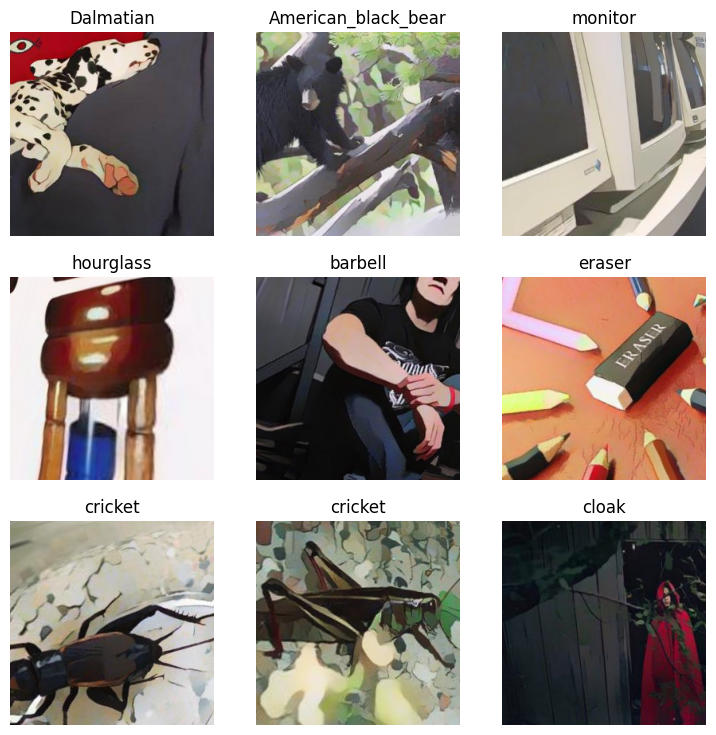

In [11]:
data.show_batch()

In [12]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

In [14]:
modelGanador = nn.Sequential(
    *bca(3, 128, k=2, s=2),
    *cba(128, 256),
    *bca(256,256,k=2,s=2),
    *cba(256,512),
    *bca(512,512,k=2,s=2),
    *cba(512,512),
    *bca(512,512,k=2,s=2),
    *cba(512,512),
    *bca(512,512,k=2,s=2),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    *lab(512, data.c)
)

In [15]:
num_params(modelGanador)

9624154

In [16]:
learnGanador = fv.Learner(data, modelGanador, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

SuggestedLRs(valley=0.00363078061491251)

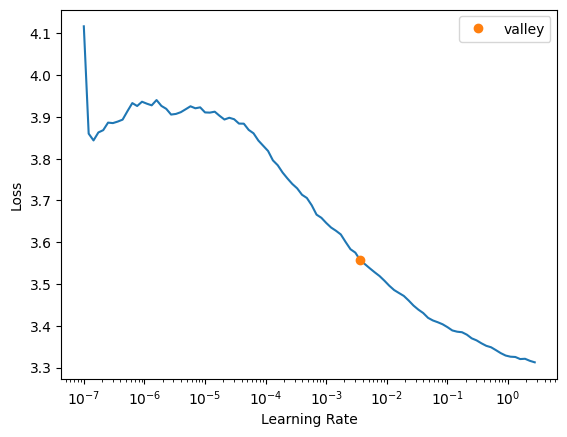

In [17]:
learnGanador.lr_find()

In [18]:
learnGanador.fit_one_cycle(12, 0.0008, div=1, pct_start=0.7)

epoch,train_loss,valid_loss,accuracy,time
0,2.446711,2.593519,0.238571,01:45
1,2.070445,2.215049,0.338571,01:46
2,1.884844,1.956687,0.412143,01:46
3,1.735272,2.229542,0.354286,01:45
4,1.641383,1.719066,0.476429,01:46
5,1.534063,1.853961,0.439286,01:45
6,1.483385,1.524238,0.530714,01:45
7,1.394468,1.470515,0.549286,01:45
8,1.318477,1.719276,0.492857,01:45
9,1.217860,1.268261,0.593571,01:45


Si es en la época final 64.5%. Si es la mejor época 65.5%